# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise e Previsão de Séries Temporais com Inteligência Artificial</font>

## <font color='blue'>Projeto 1 - Parte 2</font>
### <font color='blue'>Previsão de Vendas com Diferentes Janelas de Previsão</font>
### <font color='blue'>Previsão Para Janela de 12 Meses</font>

![DSA](imagens/P1.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
# https://www.tensorflow.org/
#!pip install -q tensorflow

In [4]:
# https://keras.io/
#!pip install -q keras

In [5]:
# Define variável de ambiente para slienciar as mensagens do TF
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [6]:
# Imports
import sklearn
import statsmodels
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [8]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pandas     : 1.5.3
statsmodels: 0.13.2
matplotlib : 3.5.2
tensorflow : 2.11.0
numpy      : 1.22.2
seaborn    : 0.11.2
keras      : 2.11.0
sklearn    : 1.0.2



## Carregando os Dados

In [9]:
# Carrega o dataset
df = pd.read_csv('dados/dataset.csv')

In [10]:
df.head()

,Mes,Vendas
0,01-01-2016,14057
1,02-01-2016,15475
2,03-01-2016,14524
3,04-01-2016,15661
4,05-01-2016,12355


In [11]:
df.tail()

,Mes,Vendas
70,11-01-2021,14568
71,12-01-2021,15661
72,01-01-2022,19108
73,02-01-2022,19202
74,03-01-2022,13623


<AxesSubplot:>

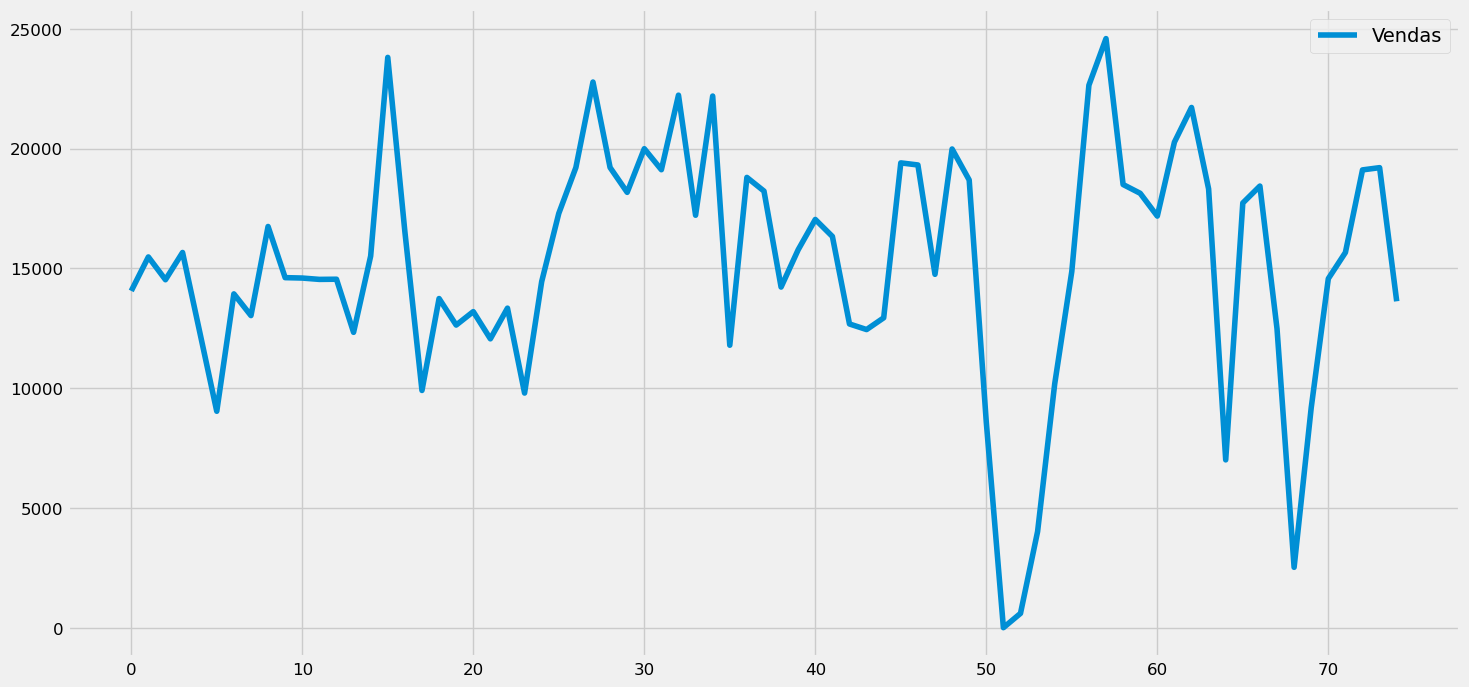

In [12]:
df.plot(figsize = (16,8))

In [13]:
df.head(12)

,Mes,Vendas
0,01-01-2016,14057
1,02-01-2016,15475
2,03-01-2016,14524
3,04-01-2016,15661
4,05-01-2016,12355
5,06-01-2016,9033
6,07-01-2016,13934
7,08-01-2016,13027
8,09-01-2016,16746
9,10-01-2016,14611


In [14]:
# Média
df['Vendas'].mean()

15189.32

In [15]:
df.describe()

,Vendas
count,75.000000
mean,15189.320000
std,4938.414767
min,0.000000
25%,12805.500000
50%,15475.000000
75%,18592.000000
max,24589.000000


Temos valores discrepantes (outliers). Vamos tratá-los usando percentil.

## Tratamento de Outliers

In [16]:
# Extrai o percentil 10
min_threshold = df['Vendas'].quantile(0.10)

In [17]:
min_threshold

9425.2

In [18]:
# Valores abaixo do threshold (limite)
amostra = df[df['Vendas'] < min_threshold]

In [19]:
amostra

,Mes,Vendas
5,06-01-2016,9033
50,03-01-2020,8575
51,04-01-2020,0
52,05-01-2020,597
53,06-01-2020,4013
64,05-01-2021,7005
68,09-01-2021,2520
69,10-01-2021,9180


In [20]:
df.count()

Mes       75
Vendas    75
dtype: int64

In [21]:
# Qualquer valor abaixo do threshold será substituído pela média (interpolação)
for i in range(75):
    if df.loc[i , 'Vendas'] < 9425.2:
        df.iat[i,1] = 15190

No pandas, iat é um método que permite acessar um único valor em um DataFrame ou Series, com base em sua posição numérica. Ele é semelhante ao método iloc, mas é otimizado para acesso a valores individuais, tornando-o mais rápido do que o iloc em casos em que é necessário acessar um único valor.

O iat tem a sintaxe iat[i, j], onde i e j são as posições numéricas do índice e da coluna, respectivamente. 

O iat pode ser útil em situações em que é necessário acessar um único valor em um DataFrame ou Series grande, porque ele é muito mais rápido do que a indexação normal usando chaves ou o método loc, que são projetados para acessar múltiplos valores simultaneamente. No entanto, como o iat acessa valores com base em sua posição numérica, é importante garantir que a ordem dos índices e colunas seja consistente em todo o DataFrame ou Series, para que o valor correto seja acessado.

In [22]:
df.head(12)

,Mes,Vendas
0,01-01-2016,14057
1,02-01-2016,15475
2,03-01-2016,14524
3,04-01-2016,15661
4,05-01-2016,12355
5,06-01-2016,15190
6,07-01-2016,13934
7,08-01-2016,13027
8,09-01-2016,16746
9,10-01-2016,14611


In [23]:
df.describe()

,Vendas
count,75.000000
mean,16263.946667
std,3296.759957
min,9793.000000
25%,14137.500000
50%,15475.000000
75%,18592.000000
max,24589.000000


In [24]:
# Converte a coluna Mes para o tipo datetime
df['Mes'] = pd.to_datetime(df['Mes'])

In [25]:
# Define o mês como índice
df.set_index('Mes', inplace = True)

In [26]:
df.head(12)

,Vendas
Mes,
2016-01-01,14057
2016-02-01,15475
2016-03-01,14524
2016-04-01,15661
2016-05-01,12355
2016-06-01,15190
2016-07-01,13934
2016-08-01,13027
2016-09-01,16746


<AxesSubplot:xlabel='Mes'>

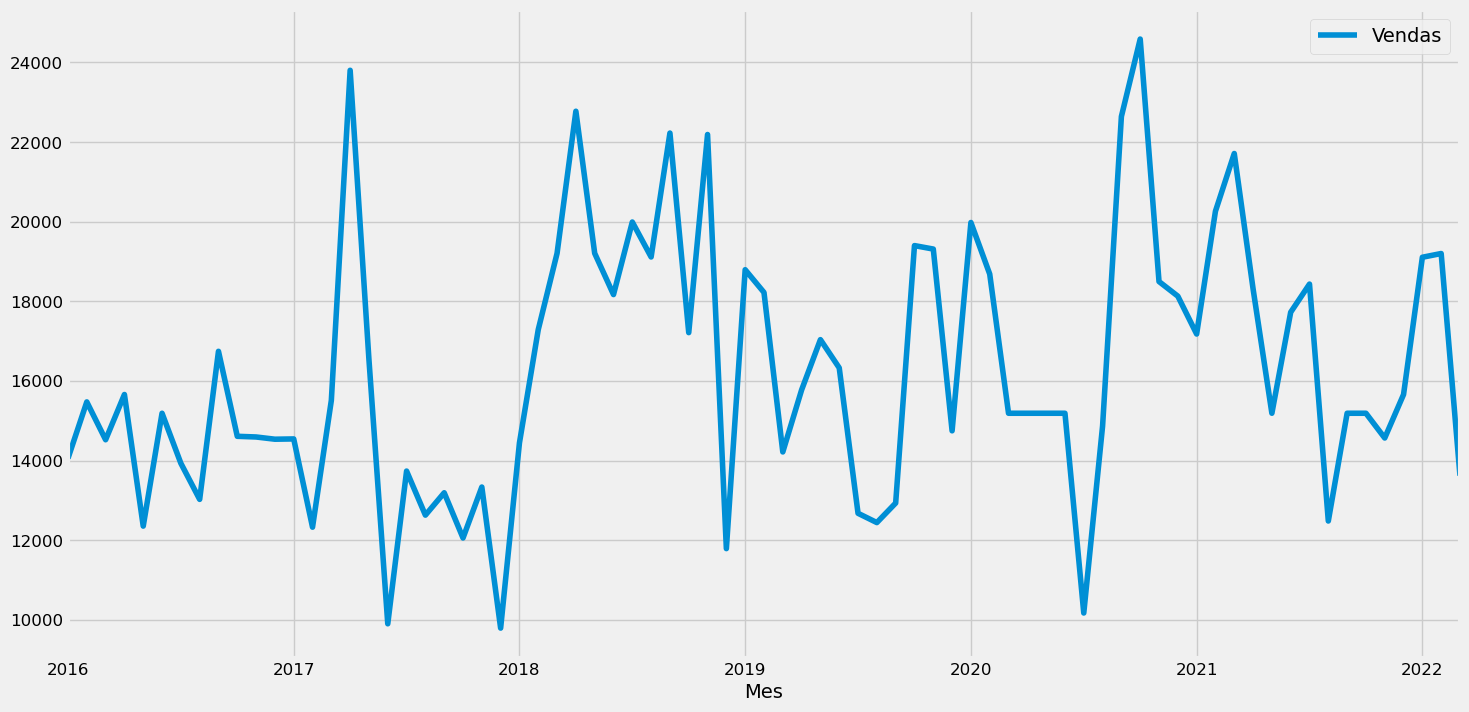

In [27]:
# Plot
df.plot(figsize = (16,8))

## Divisão em Treino e Teste e Padronização

In [28]:
len(df)

75

In [29]:
# Divisão em treino e teste
dados_treino = df.iloc[:63]
dados_teste = df.iloc[63:]

In [30]:
# Cria o padronizador
scaler = MinMaxScaler()

In [31]:
# Fit com dados de treino
scaler.fit(dados_treino)

MinMaxScaler()

In [32]:
# Transform em treino e teste
scaled_treino = scaler.transform(dados_treino)
scaled_teste = scaler.transform(dados_teste)

In [33]:
scaled_treino[:10]

array([[0.288186  ],
       [0.38402271],
       [0.31974858],
       [0.39659367],
       [0.17315491],
       [0.36476075],
       [0.27987294],
       [0.21857259],
       [0.4699243 ],
       [0.32562855]])

## Pré-Processamento da Série Temporal com TimeseriesGenerator

In [34]:
# Janela de previsão que o modelo será treinado
n_input = 12

In [35]:
# Cria o generator
generator = TimeseriesGenerator(scaled_treino, scaled_treino, length = n_input, batch_size = 1)

In [36]:
# Extrai o primeiro item do generator para visualizar
X,y = generator[0]

In [37]:
X.shape

(1, 12, 1)

In [38]:
y.shape

(1, 1)

In [39]:
print(f'\nArray de Entrada (x): \n{X.flatten()}')
print(f'\nPrevisão (y): \n {y}')


Array de Entrada (x): 
[0.288186   0.38402271 0.31974858 0.39659367 0.17315491 0.36476075
 0.27987294 0.21857259 0.4699243  0.32562855 0.32447959 0.32069478]

Previsão (y): 
 [[0.32116788]]


## Modelagem

In [40]:
# Número de atributos
n_features = 1

In [41]:
# Modelo
modelo = Sequential()
modelo.add(LSTM(200, activation = 'relu', input_shape = (n_input, n_features)))
modelo.add(Dense(1))
modelo.compile(optimizer = 'adam', loss = 'mse')

In [42]:
# Sumário
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Treinamento
modelo.fit(generator, epochs = 200)

Epoch 1/200
51/51 [==============================] - 1s 5ms/step - loss: 0.0796
Epoch 2/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0742
Epoch 3/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0623
Epoch 4/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 5/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0614
Epoch 6/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 7/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0648
Epoch 8/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0625
Epoch 9/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 10/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0610
Epoch 11/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0622
Epoch 12/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0578
Epoch 13/200
51/51 [=================

51/51 [==============================] - 0s 6ms/step - loss: 0.0333
Epoch 103/200
51/51 [==============================] - 0s 6ms/step - loss: 0.0248
Epoch 104/200
51/51 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 105/200
51/51 [==============================] - 0s 6ms/step - loss: 0.0257
Epoch 106/200
51/51 [==============================] - 0s 7ms/step - loss: 0.0329
Epoch 107/200
51/51 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 108/200
51/51 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 109/200
51/51 [==============================] - 0s 6ms/step - loss: 0.0182
Epoch 110/200
51/51 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 111/200
51/51 [==============================] - 0s 7ms/step - loss: 0.0180
Epoch 112/200
51/51 [==============================] - 0s 6ms/step - loss: 0.0229
Epoch 113/200
51/51 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 114/200
51/51 [=========

In [44]:
# Erro por epoch
loss_per_epoch = modelo.history.history['loss']

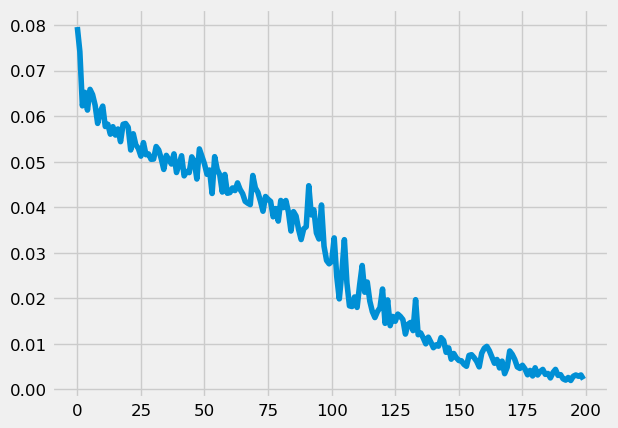

In [45]:
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [46]:
# Último batch de treino
ultimo_batch_treino = scaled_treino[-12:]

In [47]:
# Ajusta o shape
ultimo_batch_treino = ultimo_batch_treino.reshape((1, n_input, n_features))

In [48]:
# Previsão em treino
modelo.predict(ultimo_batch_treino)

1/1 [==============================] - 0s 161ms/step


array([[0.8115062]], dtype=float32)

## Previsões em Teste e Avaliação do Modelo

In [49]:
previsoes_teste = []

In [50]:
# Primeiro batch
first_eval_batch = scaled_teste[-n_input:]

In [51]:
# Batch corrente
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [52]:
current_batch

array([[[0.57603406],
        [0.36476075],
        [0.53622601],
        [0.58400919],
        [0.18180589],
        [0.36476075],
        [0.36476075],
        [0.32272236],
        [0.39659367],
        [0.62956204],
        [0.63591511],
        [0.25885374]]])

In [53]:
dados_teste.head()

,Vendas
Mes,
2021-04-01,18316
2021-05-01,15190
2021-06-01,17727
2021-07-01,18434
2021-08-01,12483


In [54]:
# Loop de previsão
for i in range(len(dados_teste)):
    
    # Obtém o valor de previsão para o primeiro lote
    current_pred = modelo.predict(current_batch)[0]
    
    # Adiciona a previsão na matriz
    previsoes_teste.append(current_pred) 
    
    # Usa a previsão para atualizar o lote e remover o primeiro valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 20ms/step


In [55]:
previsoes_teste

[array([0.2874358], dtype=float32),
 array([0.16401905], dtype=float32),
 array([0.16622794], dtype=float32),
 array([0.49235183], dtype=float32),
 array([0.31332472], dtype=float32),
 array([0.11823721], dtype=float32),
 array([0.22740018], dtype=float32),
 array([0.41041672], dtype=float32),
 array([0.39031336], dtype=float32),
 array([0.3578602], dtype=float32),
 array([0.33631292], dtype=float32),
 array([0.15715188], dtype=float32)]

In [56]:
# Inverte a padronização
true_previsoes_teste = scaler.inverse_transform(previsoes_teste)

In [57]:
# Adiciona as previsões no dataframe de dados de teste
dados_teste['Previsao'] = true_previsoes_teste

In [58]:
dados_teste.head()

,Vendas,Previsao
Mes,,
2021-04-01,18316,14045.900094
2021-05-01,15190,12219.825837
2021-06-01,17727,12252.508552
2021-07-01,18434,17077.837677
2021-08-01,12483,14428.952552


In [59]:
dados_teste.tail()

,Vendas,Previsao
Mes,,
2021-11-01,14568,15865.525823
2021-12-01,15661,15568.076432
2022-01-01,19108,15087.899631
2022-02-01,19202,14769.085962
2022-03-01,13623,12118.219185


<AxesSubplot:xlabel='Mes'>

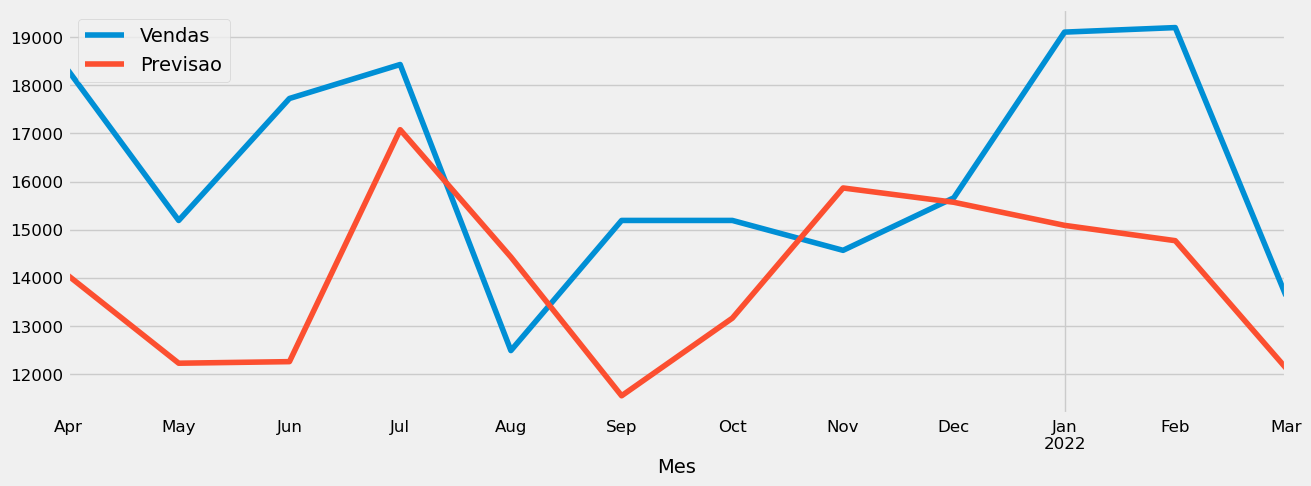

In [60]:
# Plot
dados_teste.plot(figsize = (14,5))

In [61]:
# Calcula o erro
rmse = sqrt(mean_squared_error(dados_teste['Vendas'], dados_teste['Previsao']))

In [62]:
print(rmse)

3160.3726790164665


# Fim